# Semantic Embeddings Extraction Pipeline

## Overview

This notebook extracts semantic embeddings from multiple pre-trained language models for the NatSounds dataset. We'll process "what" and "how" text columns to create numerical representations that capture semantic meaning.

## Workflow

1. **Load Data**: Read Excel file with semantic labels
2. **Preprocess Text**: Clean and prepare text data
3. **Extract Embeddings**: Use 11 different embedding models
4. **Save Results**: Store embeddings as .npy files
5. **Create Dictionary**: Organize all embeddings in one structure
6. **Visualize**: Use t-SNE to visualize embeddings in 2D

## What are Embeddings?

Embeddings are dense vector representations of text that capture semantic meaning. Similar texts have similar embeddings (close in vector space), making them perfect for:
- Similarity analysis
- Clustering
- Classification
- Visualization
- And much more!

Let's get started! 🚀


# Data Loading

First, we need to load our dataset. We're using an Excel file that contains semantic labels with "what" and "how" columns. These represent different aspects of the natural sounds we're analyzing.

The code below:
- Imports necessary libraries (pandas for data, numpy for arrays, etc.)
- Loads the Excel file into a pandas DataFrame
- Displays the data to verify it loaded correctly


In [49]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm


df = pd.read_excel("/Users/micheleesposito/Desktop/NatSoundsDataset/SemanticModelsEmbeddings/data/sem_labels_common_unique_sets_v03.xlsx", engine = 'openpyxl')  
df


,wav_name,orig_name,what,how,whathow,orig_cat
0,Sou001_SetComm_Clu01RingType_Fsd50k_113_BellRi...,113_BellRinging_147648.wav,bell,ringing,bell ringing,113
1,Sou002_SetComm_Clu01RingType_Fsd50k_114_BellJi...,114_BellJingling_371221.wav,bell,jingling,bell jingling,114
2,Sou003_SetComm_Clu01RingType_Fsd50k_115_Bicycl...,115_BicycleRinging_383597.wav,bicycle,ringing,bicycle ringing,115
3,Sou004_SetComm_Clu01RingType_Fsd50k_117_WindCh...,117_WindChimeRinging_182625.wav,wind_chime,ringing,wind_chime ringing,117
4,Sou005_SetComm_Clu01RingType_Fsd50k_185_Keyboa...,185_KeyboardTyping_125548.wav,keyboard,typing,keyboard typing,185
...,...,...,...,...,...,...
595,Sou596_SetUni3_Clu15AnimDome_Fsd50k_043_CatMeo...,43_CatMeowing_214759.wav,cat,meowing,cat meowing,43
596,Sou597_SetUni3_Clu15AnimDome_Fsd50k_044_HorseN...,44_HorseNeighing_32853.wav,horse,neighing,horse neighing,44
597,Sou598_SetUni3_Clu15AnimDome_Fsd50k_045_HorseC...,45_HorseClipClopping_23500.wav,horse,clip_clopping,horse clip_clopping,45
598,Sou599_SetUni3_Clu15AnimDome_Fsd50k_048_PigOin...,48_PigOinking_330704.wav,pig,oinking,pig oinking,48


## Text Preprocessing

Before extracting embeddings, we need to prepare our text data:

1. **Extract text columns**: Convert the "what" and "how" columns to lists of strings
2. **Create combined texts**: Concatenate "what" and "how" to create "what_how" texts
3. **Clean the text**: Replace underscores with spaces because:
   - Some embedding models don't recognize words with underscores
   - Underscores can cause out-of-vocabulary (OOV) issues
   - Spaces are more natural for tokenization

**Why clean underscores?**
- Example: "bird_call" → "bird call"
- This ensures models can find both words in their vocabulary
- Prevents embedding failures for words with underscores


## Model 1: Word2Vec

**Word2Vec** is one of the earliest and most popular word embedding models. It learns word representations by predicting words in context using a neural network.

### How Word2Vec Works:
- **Training**: Learns from large text corpora (we use Google's pre-trained model with 3M words)
- **Output**: Each word gets a 300-dimensional vector
- **Sentence embedding**: For multi-word texts, we average all word vectors

### Why Average Word Vectors?
- Word2Vec produces word-level embeddings, not sentence-level
- To get a sentence representation, we average all word vectors in the sentence
- This gives us a single 300-dimensional vector per text

**Note**: If a word isn't in the vocabulary, we use a zero vector for that word.


In [20]:

# Assumi colonne: “what”, “how”
texts_what = df["what"].astype(str).tolist()
texts_how  = df["how"].astype(str).tolist()
texts_what_how = [w + " " + h for w, h in zip(texts_what, texts_how)]

# Funzione per rimuovere underscore dalle parole (sostituisce con spazi)
# Questo è necessario perché le parole con underscore potrebbero non essere nel dizionario dei modelli
def clean_text_underscores(text_list):
    """
    Rimuove gli underscore dalle parole sostituendoli con spazi.
    Esempio: "bird_call" -> "bird call"
    """
    cleaned = []
    for text in text_list:
        # Sostituisce underscore con spazi
        cleaned_text = text.replace("_", " ")
        cleaned.append(cleaned_text)
    return cleaned

# Pulisce i testi rimuovendo gli underscore
print("Cleaning texts: removing underscores from words...")
texts_what_original = texts_what.copy()
texts_how_original = texts_how.copy()
texts_what_how_original = texts_what_how.copy()

texts_what = clean_text_underscores(texts_what)
texts_how = clean_text_underscores(texts_how)
texts_what_how = clean_text_underscores(texts_what_how)

# Mostra alcuni esempi di pulizia
print("\nExamples of cleaned texts:")
print(f"  Original 'what': {texts_what_original[:3]}")
print(f"  Cleaned 'what':  {texts_what[:3]}")
print(f"  Original 'how':  {texts_how_original[:3]}")
print(f"  Cleaned 'how':   {texts_how[:3]}")
print()

# Funzione per salvataggio
def save_embeddings(array, out_path):
    np.save(out_path, array)

# === Modello A: Word2Vec ===
from gensim.models import KeyedVectors
import gzip

# Carica il modello Word2Vec pre-allenato
print("Loading Word2Vec model...")
w2v_model = KeyedVectors.load_word2vec_format(
    '/Users/micheleesposito/GoogleNews-vectors-negative300.bin.gz',
    binary=True
)
print(f"Word2Vec model loaded! Vocabulary size: {len(w2v_model)}")

def embed_word2vec(model, texts):
    embeddings = []
    for text in texts:
        tokens = text.split()
        vecs = [model[t] for t in tokens if t in model]
        if len(vecs)>0:
            embeddings.append(np.mean(vecs, axis=0))
        else:
            embeddings.append(np.zeros(model.vector_size))
    return np.vstack(embeddings)


Cleaning texts: removing underscores from words...

Examples of cleaned texts:
  Original 'what': ['bell', 'bell', 'bicycle']
  Cleaned 'what':  ['bell', 'bell', 'bicycle']
  Original 'how':  ['ringing', 'jingling', 'ringing']
  Cleaned 'how':   ['ringing', 'jingling', 'ringing']

Loading Word2Vec model...
Word2Vec model loaded! Vocabulary size: 3000000


## Model 2: BERT (Bidirectional Encoder Representations from Transformers)

**BERT** revolutionized NLP by introducing bidirectional context understanding. Unlike previous models that read text left-to-right, BERT reads in both directions simultaneously.

### Key Features:
- **Bidirectional**: Understands context from both sides of a word
- **Transformer architecture**: Uses self-attention to capture relationships
- **Pre-trained**: Trained on massive text corpora (Wikipedia + Books)
- **Contextual**: Same word gets different embeddings based on context

### How We Extract Embeddings:
1. **Tokenization**: Text is split into tokens (words/subwords)
2. **Add special tokens**: `[CLS]` at start, `[SEP]` for separation
3. **Process through BERT**: All tokens go through 12 transformer layers
4. **Extract [CLS] token**: The first token's embedding represents the entire sentence

The [CLS] token accumulates information from all other tokens through self-attention, making it perfect for sentence-level tasks!


In [21]:

# Calcola:
emb_w2v_what = embed_word2vec(w2v_model, texts_what)
emb_w2v_how  = embed_word2vec(w2v_model, texts_how)
emb_w2v_wh   = embed_word2vec(w2v_model, texts_what_how)

# # Salva:
save_embeddings(emb_w2v_what, "../outputs/embeddings_word2vec/what.npy")
save_embeddings(emb_w2v_how,  "../outputs/embeddings_word2vec/how.npy")
save_embeddings(emb_w2v_wh,   "../outputs/embeddings_word2vec/what_how.npy")


## Model 3: Sentence-Transformers

**Sentence-Transformers** are models specifically designed for sentence embeddings. They're built on top of transformer models (like BERT) but are fine-tuned to produce better sentence-level representations.

### Advantages:
- **Optimized for sentences**: Trained on sentence similarity tasks
- **Better semantic understanding**: Captures sentence meaning more accurately
- **Efficient**: Uses mean pooling or other techniques optimized for sentences
- **Ready to use**: No need to extract CLS tokens manually

### How It Works:
- Uses a transformer backbone (like BERT or MPNet)
- Fine-tuned on sentence pairs (e.g., paraphrase detection)
- Produces embeddings optimized for semantic similarity tasks

We're using `all-mpnet-base-v2` which is one of the best-performing sentence transformer models!


## Model 4: FastText

**FastText** is Facebook's word embedding model that extends Word2Vec with subword information.

### Key Innovation:
- **Subword embeddings**: Breaks words into character n-grams
- **Handles OOV words**: Can generate embeddings for words not in training data
- **Better for morphologically rich languages**: Handles prefixes, suffixes, etc.

### How It Works:
- Each word is represented as a bag of character n-grams
- Embedding = sum of n-gram embeddings
- For sentences: average all word embeddings (like Word2Vec)

**Example**: The word "running" might be broken into: "run", "unn", "nni", "nin", "ing", etc.


## Model 5: GloVe (Global Vectors for Word Representation)

**GloVe** (Global Vectors) is Stanford's word embedding model that combines the best of both worlds: global matrix factorization and local context window methods.

### How GloVe Works:
- **Global statistics**: Uses word co-occurrence statistics from entire corpus
- **Matrix factorization**: Decomposes word-word co-occurrence matrix
- **Efficient**: Captures both local and global word relationships

### Key Difference from Word2Vec:
- Word2Vec: Predicts words in local context windows
- GloVe: Uses global word co-occurrence statistics
- Both produce similar quality embeddings but through different approaches

For sentence embeddings, we average word vectors (same as Word2Vec).


## Model 6: RoBERTa (Robustly Optimized BERT Pretraining Approach)

**RoBERTa** is Facebook's improved version of BERT. It's not a new architecture, but rather BERT with better training strategies.

### Improvements over BERT:
- **More training data**: Trained on 10x more data
- **Longer training**: Trained for more steps
- **Removed NSP task**: Dropped Next Sentence Prediction (found to be unnecessary)
- **Dynamic masking**: Changes mask pattern during training (BERT uses static masking)
- **Larger batch sizes**: Better optimization

### Result:
- Better performance on most NLP tasks
- Same architecture, just better trained
- Uses [CLS] token like BERT for sentence embeddings


## Model 7: DistilBERT

**DistilBERT** is a smaller, faster, and lighter version of BERT created through knowledge distillation.

### Knowledge Distillation:
- **Teacher model**: Original BERT (large, accurate)
- **Student model**: Smaller BERT (DistilBERT)
- **Process**: Student learns from teacher's predictions
- **Result**: 60% smaller, 60% faster, 97% of BERT's performance!

### Architecture Changes:
- 6 layers instead of 12 (half the size)
- Same hidden size (768 dimensions)
- Same [CLS] token extraction method

### When to Use:
- When you need speed and efficiency
- When model size matters (mobile, edge devices)
- When 97% performance is acceptable


## Model 8: GPT-2 (Generative Pre-trained Transformer 2)

**GPT-2** is OpenAI's generative language model. Unlike BERT, it's a decoder-only model designed for text generation.

### Key Differences from BERT:
- **Unidirectional**: Reads text left-to-right only (not bidirectional)
- **No [CLS] token**: Doesn't have a special classification token
- **Autoregressive**: Predicts next token given previous tokens
- **Generative**: Designed for text generation, not classification

### How We Extract Embeddings:
Since GPT-2 has no [CLS] token, we use **mean pooling**:
1. Get embeddings for all tokens in the sequence
2. Average them together (excluding padding tokens)
3. Result: Single vector representing the entire sequence

**Why mean pooling?**
- No special token exists for sentence representation
- Averaging captures information from all tokens
- Works well for sentence-level tasks despite being a generative model


## Model 9: Multilingual BERT (mBERT)

**Multilingual BERT** is BERT trained on 104 languages simultaneously. It can handle text in multiple languages without language-specific models.

### Key Features:
- **104 languages**: Trained on Wikipedia in 104 languages
- **Shared vocabulary**: Uses a multilingual vocabulary
- **Cross-lingual**: Can understand relationships across languages
- **Same architecture**: Identical to BERT-base (12 layers, 768 dims)

### How It Works:
- Tokenizes text in any of the 104 languages
- Uses shared multilingual vocabulary
- Produces embeddings that capture cross-lingual semantics
- Uses [CLS] token like standard BERT

**Use case**: Perfect when your data might contain multiple languages or you need cross-lingual understanding!


## Understanding [CLS] Tokens in Transformer Models

### What is a [CLS] Token?

The **[CLS]** (Classification) token is a special token added at the beginning of input sequences in BERT and similar transformer models. It serves as a **sentence-level representation** of the entire input.

### How [CLS] Tokens Work:

1. **Input Processing**: When text is tokenized, a `[CLS]` token is automatically prepended to the sequence:
   ```
   Original: "the cat sat on the mat"
   Tokenized: ["[CLS]", "the", "cat", "sat", "on", "the", "mat"]
   ```

2. **Contextual Encoding**: As the sequence passes through BERT's transformer layers:
   - Each token (including `[CLS]`) attends to all other tokens in the sequence
   - The `[CLS]` token accumulates information from the entire sequence through self-attention
   - After all layers, `[CLS]` contains a contextualized representation of the whole input

3. **Why Use [CLS]?**:
   - **Single vector representation**: One fixed-size vector (768 dimensions for BERT-base) for the entire sequence
   - **Context-aware**: Contains information about all tokens and their relationships
   - **Task-agnostic**: Works well for various downstream tasks (classification, similarity, etc.)

### Extracting [CLS] Embeddings:

In the code below, we extract the `[CLS]` token embedding using:
```python
cls_vec = outputs.last_hidden_state[:,0,:]
```

This means:
- `last_hidden_state`: The hidden states from the final transformer layer
- `[:,0,:]`: All batches, token at index 0 (the `[CLS]` token), all dimensions
- Result: A 768-dimensional vector representing the entire input sequence

### Alternative Approaches:

- **Mean Pooling**: Average all token embeddings (used in GPT-2 since it has no `[CLS]` token)
- **Max Pooling**: Take maximum value across tokens for each dimension
- **Last Token**: Use the last token's embedding (common in GPT models)


## t-SNE Visualization

**t-SNE** (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique perfect for visualizing high-dimensional embeddings in 2D or 3D.

### What t-SNE Does:
- **Reduces dimensions**: Projects high-dimensional embeddings (300-768D) to 2D
- **Preserves local structure**: Similar embeddings stay close together
- **Non-linear**: Captures complex relationships that PCA can't

### How It Works:
1. **High-dimensional space**: Embeddings are in 300-768 dimensional space
2. **Similarity calculation**: Computes pairwise similarities
3. **Low-dimensional mapping**: Maps to 2D while preserving similarities
4. **Visualization**: Plot points in 2D - clusters indicate semantic similarity

### Parameters:
- **perplexity**: Controls how many neighbors each point considers (default: 30)
  - Lower = focuses on local structure
  - Higher = considers more global structure
- **random_state**: Ensures reproducible results

**Note**: We modified the function to show only **unique text labels** to avoid cluttering the plot with duplicates!


In [50]:

# === Modello B: BERT (trasformers) ===
from transformers import AutoTokenizer, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  # o modello multilingue
model     = AutoModel.from_pretrained("bert-base-uncased")
model.eval()

def embed_bert(texts, batch_size=32):
    """
    Extract embeddings from BERT model using the [CLS] token.
    
    The [CLS] token is a special classification token added at the beginning of each input sequence.
    After processing through BERT's transformer layers, the [CLS] token's embedding contains
    a contextualized representation of the entire input sequence, making it ideal for sentence-level tasks.
    
    Parameters:
    -----------
    texts : list of str
        List of input texts to embed
    batch_size : int
        Number of texts to process in each batch (default: 32)
    
    Returns:
    --------
    numpy.ndarray
        Array of shape (n_texts, 768) containing the [CLS] token embeddings
    """
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        with torch.no_grad():  # Disable gradient computation for inference (faster, less memory)
            # Tokenize the batch: convert text to token IDs, add padding, truncate if too long
            encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
            # Pass through BERT model to get hidden states
            outputs = model(**encoded)
            # Extract [CLS] token embedding: last_hidden_state[:,0,:] means:
            #   - [:,0,:] = all batches, first token (index 0 = [CLS]), all dimensions
            #   - The [CLS] token is at position 0 in the sequence
            cls_vec = outputs.last_hidden_state[:,0,:].cpu().numpy()
            embeddings.append(cls_vec)
    return np.vstack(embeddings)  # Stack all batch embeddings into a single array

emb_bert_what = embed_bert(texts_what)
emb_bert_how  = embed_bert(texts_how)
emb_bert_wh   = embed_bert(texts_what_how)

save_embeddings(emb_bert_what, "../outputs/embeddings_bert/what.npy")
save_embeddings(emb_bert_how,  "../outputs/embeddings_bert/how.npy")
save_embeddings(emb_bert_wh,   "../outputs/embeddings_bert/what_how.npy")


## Creating the Embeddings Dictionary

After extracting embeddings from all models, we organize them into a single Python dictionary for easy access.

### Why a Dictionary?
- **Centralized access**: All embeddings in one place
- **Easy to use**: Simple key-value access
- **Efficient**: Load once, use many times
- **Organized**: Clear structure (model → type → embeddings)

### Dictionary Structure:
```python
{
    'model_name': {
        'what': numpy_array,      # Embeddings for "what" texts
        'how': numpy_array,        # Embeddings for "how" texts
        'what_how': numpy_array   # Embeddings for combined texts
    },
    ...
}
```

### Saving with Pickle:
We save the entire dictionary as a `.pkl` file so you can:
- Load all embeddings instantly (no need to load individual .npy files)
- Share embeddings easily
- Use in other scripts without re-running the extraction

**File location**: `outputs/all_embeddings_dict.pkl`


In [51]:

# === Modello C: Sentence-Transformers ===
from sentence_transformers import SentenceTransformer
smodel = SentenceTransformer("all-mpnet-base-v2")  # oppure modello multilingue


In [52]:

emb_sst_what = smodel.encode(texts_what, show_progress_bar=True)
emb_sst_how  = smodel.encode(texts_how, show_progress_bar=True)
emb_sst_wh   = smodel.encode(texts_what_how, show_progress_bar=True)

save_embeddings(emb_sst_what, "../outputs/embeddings_sentence-transformer/what.npy")
save_embeddings(emb_sst_how,  "../outputs/embeddings_sentence-transformer/how.npy")
save_embeddings(emb_sst_wh,   "../outputs/embeddings_sentence-transformer/what_how.npy")

print("Sentence-Transformer (all-mpnet-base-v2) embeddings saved!")


Batches: 100%|██████████| 19/19 [00:00<00:00, 101.43it/s]

Sentence-Transformer (all-mpnet-base-v2) embeddings saved!


In [53]:
# === Modello D: FastText ===
# FastText supports subword embeddings and can handle out-of-vocabulary words
from gensim.models import FastText
# Note: You can download pre-trained FastText models from https://fasttext.cc/docs/en/pretrained-vectors.html
# For now, we'll use a pre-trained model if available, or train a small one
# Example: Load pre-trained FastText model (if you have it)
# ft_model = FastText.load_fasttext_format('path/to/fasttext/model.bin')

# Alternative: Use gensim's downloader to get a pre-trained model
import gensim.downloader as api
print("Loading FastText model...")
try:
    ft_model = api.load("fasttext-wiki-news-subwords-300")
    print(f"FastText model loaded! Vocabulary size: {len(ft_model)}")
except:
    print("FastText pre-trained model not available. Skipping FastText embeddings.")
    ft_model = None

def embed_fasttext(model, texts):
    if model is None:
        return None
    embeddings = []
    for text in texts:
        tokens = text.split()
        vecs = [model[t] for t in tokens]
        if len(vecs)>0:
            embeddings.append(np.mean(vecs, axis=0))
        else:
            embeddings.append(np.zeros(model.vector_size))
    return np.vstack(embeddings)

if ft_model is not None:
    emb_ft_what = embed_fasttext(ft_model, texts_what)
    emb_ft_how  = embed_fasttext(ft_model, texts_how)
    emb_ft_wh   = embed_fasttext(ft_model, texts_what_how)
    
    save_embeddings(emb_ft_what, "../outputs/embeddings_fasttext/what.npy")
    save_embeddings(emb_ft_how,  "../outputs/embeddings_fasttext/how.npy")
    save_embeddings(emb_ft_wh,   "../outputs/embeddings_fasttext/what_how.npy")
    print("FastText embeddings saved!")


Loading FastText model...
FastText model loaded! Vocabulary size: 999999
FastText embeddings saved!


In [54]:
# === Modello E: GloVe ===
# GloVe (Global Vectors for Word Representation)
print("Loading GloVe model...")
try:
    glove_model = api.load("glove-wiki-gigaword-300")
    print(f"GloVe model loaded! Vocabulary size: {len(glove_model)}")
except:
    print("GloVe pre-trained model not available. Skipping GloVe embeddings.")
    glove_model = None

def embed_glove(model, texts):
    if model is None:
        return None
    embeddings = []
    for text in texts:
        tokens = text.split()
        vecs = [model[t] for t in tokens if t in model]
        if len(vecs)>0:
            embeddings.append(np.mean(vecs, axis=0))
        else:
            embeddings.append(np.zeros(model.vector_size))
    return np.vstack(embeddings)

if glove_model is not None:
    emb_glove_what = embed_glove(glove_model, texts_what)
    emb_glove_how  = embed_glove(glove_model, texts_how)
    emb_glove_wh   = embed_glove(glove_model, texts_what_how)
    
    save_embeddings(emb_glove_what, "../outputs/embeddings_glove/what.npy")
    save_embeddings(emb_glove_how,  "../outputs/embeddings_glove/how.npy")
    save_embeddings(emb_glove_wh,   "../outputs/embeddings_glove/what_how.npy")
    print("GloVe embeddings saved!")


Loading GloVe model...
GloVe pre-trained model not available. Skipping GloVe embeddings.


In [ ]:
# === Modello F: RoBERTa ===
# RoBERTa (Robustly Optimized BERT Pretraining Approach)
print("Loading RoBERTa model...")
roberta_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
roberta_model = AutoModel.from_pretrained("roberta-base")
roberta_model.eval()

def embed_roberta(texts, batch_size=32):
    """
    Extract embeddings from RoBERTa model using the [CLS] token.
    
    RoBERTa (Robustly Optimized BERT Pretraining Approach) is an improved version of BERT.
    Like BERT, it uses a [CLS] token at position 0 for sentence-level representations.
    The [CLS] token embedding captures the entire sequence's contextual information.
    
    Parameters:
    -----------
    texts : list of str
        List of input texts to embed
    batch_size : int
        Number of texts to process in each batch (default: 32)
    
    Returns:
    --------
    numpy.ndarray
        Array of shape (n_texts, 768) containing the [CLS] token embeddings
    """
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        with torch.no_grad():  # Disable gradients for inference
            # Tokenize and encode the batch
            encoded = roberta_tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
            # Get model outputs (hidden states from all layers)
            outputs = roberta_model(**encoded)
            # Extract [CLS] token embedding (first token, index 0)
            cls_vec = outputs.last_hidden_state[:,0,:].cpu().numpy()
            embeddings.append(cls_vec)
    return np.vstack(embeddings)  # Combine all batches

emb_roberta_what = embed_roberta(texts_what)
emb_roberta_how  = embed_roberta(texts_how)
emb_roberta_wh   = embed_roberta(texts_what_how)

save_embeddings(emb_roberta_what, "../outputs/embeddings_roberta/what.npy")
save_embeddings(emb_roberta_how,  "../outputs/embeddings_roberta/how.npy")
save_embeddings(emb_roberta_wh,   "../outputs/embeddings_roberta/what_how.npy")
print("RoBERTa embeddings saved!")


Loading RoBERTa model...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa embeddings saved!


In [ ]:
# === Modello G: DistilBERT ===
# DistilBERT - lighter and faster version of BERT
print("Loading DistilBERT model...")
distilbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
distilbert_model = AutoModel.from_pretrained("distilbert-base-uncased")
distilbert_model.eval()

def embed_distilbert(texts, batch_size=32):
    """
    Extract embeddings from DistilBERT model using the [CLS] token.
    
    DistilBERT is a smaller, faster, and lighter version of BERT (60% of BERT's size).
    It maintains 97% of BERT's performance while being faster and using less memory.
    Like BERT, it uses [CLS] token at position 0 for sentence representations.
    
    Parameters:
    -----------
    texts : list of str
        List of input texts to embed
    batch_size : int
        Number of texts to process in each batch (default: 32)
    
    Returns:
    --------
    numpy.ndarray
        Array of shape (n_texts, 768) containing the [CLS] token embeddings
    """
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        with torch.no_grad():  # Disable gradients for inference
            # Tokenize and encode the batch
            encoded = distilbert_tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
            # Get model outputs
            outputs = distilbert_model(**encoded)
            # Extract [CLS] token embedding (first token, index 0)
            cls_vec = outputs.last_hidden_state[:,0,:].cpu().numpy()
            embeddings.append(cls_vec)
    return np.vstack(embeddings)  # Combine all batches

emb_distilbert_what = embed_distilbert(texts_what)
emb_distilbert_how  = embed_distilbert(texts_how)
emb_distilbert_wh   = embed_distilbert(texts_what_how)

save_embeddings(emb_distilbert_what, "../outputs/embeddings_distilbert/what.npy")
save_embeddings(emb_distilbert_how,  "../outputs/embeddings_distilbert/how.npy")
save_embeddings(emb_distilbert_wh,   "../outputs/embeddings_distilbert/what_how.npy")
print("DistilBERT embeddings saved!")


Loading DistilBERT model...
DistilBERT embeddings saved!


In [ ]:
# === Modello I: GPT-2 (from Hugging Face) ===
# GPT-2 - Generative Pre-trained Transformer 2
# Note: GPT models don't have a [CLS] token like BERT, so we use mean pooling
print("Loading GPT-2 model...")
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt2_model = AutoModel.from_pretrained("gpt2")
gpt2_model.eval()

# Add padding token if it doesn't exist
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

def embed_gpt2(texts, batch_size=32):
    """
    Extract embeddings from GPT-2 using mean pooling of all token embeddings.
    GPT-2 doesn't have a [CLS] token, so we average all token embeddings.
    """
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        with torch.no_grad():
            encoded = gpt2_tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
            outputs = gpt2_model(**encoded)
            # Get last hidden state (batch_size, seq_len, hidden_size)
            last_hidden = outputs.last_hidden_state
            # Create attention mask to exclude padding tokens
            attention_mask = encoded['attention_mask']
            # Expand attention mask to match hidden state dimensions
            mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
            # Sum embeddings, excluding padding
            sum_embeddings = torch.sum(last_hidden * mask_expanded, dim=1)
            # Count non-padding tokens
            sum_mask = torch.clamp(mask_expanded.sum(dim=1), min=1e-9)
            # Mean pooling
            mean_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
            embeddings.append(mean_embeddings)
    return np.vstack(embeddings)

emb_gpt2_what = embed_gpt2(texts_what)
emb_gpt2_how  = embed_gpt2(texts_how)
emb_gpt2_wh   = embed_gpt2(texts_what_how)

os.makedirs("../outputs/embeddings_gpt2", exist_ok=True)
save_embeddings(emb_gpt2_what, "../outputs/embeddings_gpt2/what.npy")
save_embeddings(emb_gpt2_how,  "../outputs/embeddings_gpt2/how.npy")
save_embeddings(emb_gpt2_wh,   "../outputs/embeddings_gpt2/what_how.npy")
print("GPT-2 embeddings saved!")


Loading GPT-2 model...
GPT-2 embeddings saved!


In [ ]:
# === Modello H: Multilingual BERT ===
# Multilingual BERT for handling multiple languages
print("Loading Multilingual BERT model...")
mbert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
mbert_model = AutoModel.from_pretrained("bert-base-multilingual-cased")
mbert_model.eval()

def embed_mbert(texts, batch_size=32):
    """
    Extract embeddings from Multilingual BERT model using the [CLS] token.
    
    Multilingual BERT (mBERT) is trained on 104 languages and can handle
    text in multiple languages. Like standard BERT, it uses [CLS] token at
    position 0 for sentence-level representations.
    
    Parameters:
    -----------
    texts : list of str
        List of input texts to embed (can be in multiple languages)
    batch_size : int
        Number of texts to process in each batch (default: 32)
    
    Returns:
    --------
    numpy.ndarray
        Array of shape (n_texts, 768) containing the [CLS] token embeddings
    """
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        with torch.no_grad():  # Disable gradients for inference
            # Tokenize and encode the batch (handles multiple languages)
            encoded = mbert_tokenizer(batch, padding=True, truncation=True, return_tensors="pt")
            # Get model outputs
            outputs = mbert_model(**encoded)
            # Extract [CLS] token embedding (first token, index 0)
            cls_vec = outputs.last_hidden_state[:,0,:].cpu().numpy()
            embeddings.append(cls_vec)
    return np.vstack(embeddings)  # Combine all batches

emb_mbert_what = embed_mbert(texts_what)
emb_mbert_how  = embed_mbert(texts_how)
emb_mbert_wh   = embed_mbert(texts_what_how)

save_embeddings(emb_mbert_what, "../outputs/embeddings_multilingual_bert/what.npy")
save_embeddings(emb_mbert_how,  "../outputs/embeddings_multilingual_bert/how.npy")
save_embeddings(emb_mbert_wh,   "../outputs/embeddings_multilingual_bert/what_how.npy")
print("Multilingual BERT embeddings saved!")


Loading Multilingual BERT model...
Multilingual BERT embeddings saved!


In [ ]:
# === Modello I: Additional Sentence-Transformer Models ===
# Let's add a few more sentence transformer models for variety

# 1. all-MiniLM-L6-v2 - faster and smaller
print("Loading Sentence-Transformer: all-MiniLM-L6-v2...")
smodel_minilm = SentenceTransformer("all-MiniLM-L6-v2")

emb_minilm_what = smodel_minilm.encode(texts_what, show_progress_bar=True)
emb_minilm_how  = smodel_minilm.encode(texts_how, show_progress_bar=True)
emb_minilm_wh   = smodel_minilm.encode(texts_what_how, show_progress_bar=True)

os.makedirs("../outputs/embeddings_minilm", exist_ok=True)
save_embeddings(emb_minilm_what, "../outputs/embeddings_minilm/what.npy")
save_embeddings(emb_minilm_how,  "../outputs/embeddings_minilm/how.npy")
save_embeddings(emb_minilm_wh,   "../outputs/embeddings_minilm/what_how.npy")
print("all-MiniLM-L6-v2 embeddings saved!")

# 2. all-mpnet-base-v2 (already done above, but we can add multilingual)
print("Loading Sentence-Transformer: paraphrase-multilingual-mpnet-base-v2...")
try:
    smodel_multilingual = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
    
    emb_multilingual_what = smodel_multilingual.encode(texts_what, show_progress_bar=True)
    emb_multilingual_how  = smodel_multilingual.encode(texts_how, show_progress_bar=True)
    emb_multilingual_wh   = smodel_multilingual.encode(texts_what_how, show_progress_bar=True)
    
    os.makedirs("../outputs/embeddings_multilingual_st", exist_ok=True)
    save_embeddings(emb_multilingual_what, "../outputs/embeddings_multilingual_st/what.npy")
    save_embeddings(emb_multilingual_how,  "../outputs/embeddings_multilingual_st/how.npy")
    save_embeddings(emb_multilingual_wh,   "../outputs/embeddings_multilingual_st/what_how.npy")
    print("Multilingual Sentence-Transformer embeddings saved!")
except Exception as e:
    print(f"Could not load multilingual sentence transformer: {e}")


Loading Sentence-Transformer: all-MiniLM-L6-v2...


Batches: 100%|██████████| 19/19 [00:00<00:00, 55.79it/s]


all-MiniLM-L6-v2 embeddings saved!
Loading Sentence-Transformer: paraphrase-multilingual-mpnet-base-v2...


Batches: 100%|██████████| 19/19 [00:00<00:00, 56.63it/s]

Multilingual Sentence-Transformer embeddings saved!


In [ ]:
# Summary: All embeddings extracted!
print("\n" + "="*50)
print("SUMMARY: All semantic embeddings have been extracted!")
print("="*50)
print("\nModels used:")
print("  1. Word2Vec (GoogleNews)")
print("  2. BERT (bert-base-uncased)")
print("  3. Sentence-Transformer (all-mpnet-base-v2)")
print("  4. FastText (if available)")
print("  5. GloVe (if available)")
print("  6. RoBERTa")
print("  7. DistilBERT")
print("  8. Multilingual BERT")
print("  9. Sentence-Transformer (all-MiniLM-L6-v2)")
print("  10. Multilingual Sentence-Transformer (if available)")
print("\nAll embeddings saved in ../outputs/")
print("="*50)



SUMMARY: All semantic embeddings have been extracted!

Models used:
  1. Word2Vec (GoogleNews)
  2. BERT (bert-base-uncased)
  3. Sentence-Transformer (all-mpnet-base-v2)
  4. FastText (if available)
  5. GloVe (if available)
  6. RoBERTa
  7. DistilBERT
  8. Multilingual BERT
  9. Sentence-Transformer (all-MiniLM-L6-v2)
  10. Multilingual Sentence-Transformer (if available)

All embeddings saved in ../outputs/


Loading embeddings for 'bert'...
  - 'what' embeddings shape: (600, 768)
  - 'how' embeddings shape: (600, 768)
  - 'what_how' embeddings shape: (600, 768)

Applying t-SNE (perplexity=50)...
  - Reducing 'what' embeddings...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.000s...
[t-SNE] Computed neighbors for 600 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 0.000022
[t-SNE] KL divergence after 100 iterations with early exaggeration: 57.081039
[t-SNE] KL divergence after 1000 iterations: -0.826195
  - Reducing 'how' embeddings...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.000s...
[t-SNE] Computed neighbors for 600 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 1.538527
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.759689
[t-SNE] KL divergence after 1000 iterations: -1.104009
  - Reduci

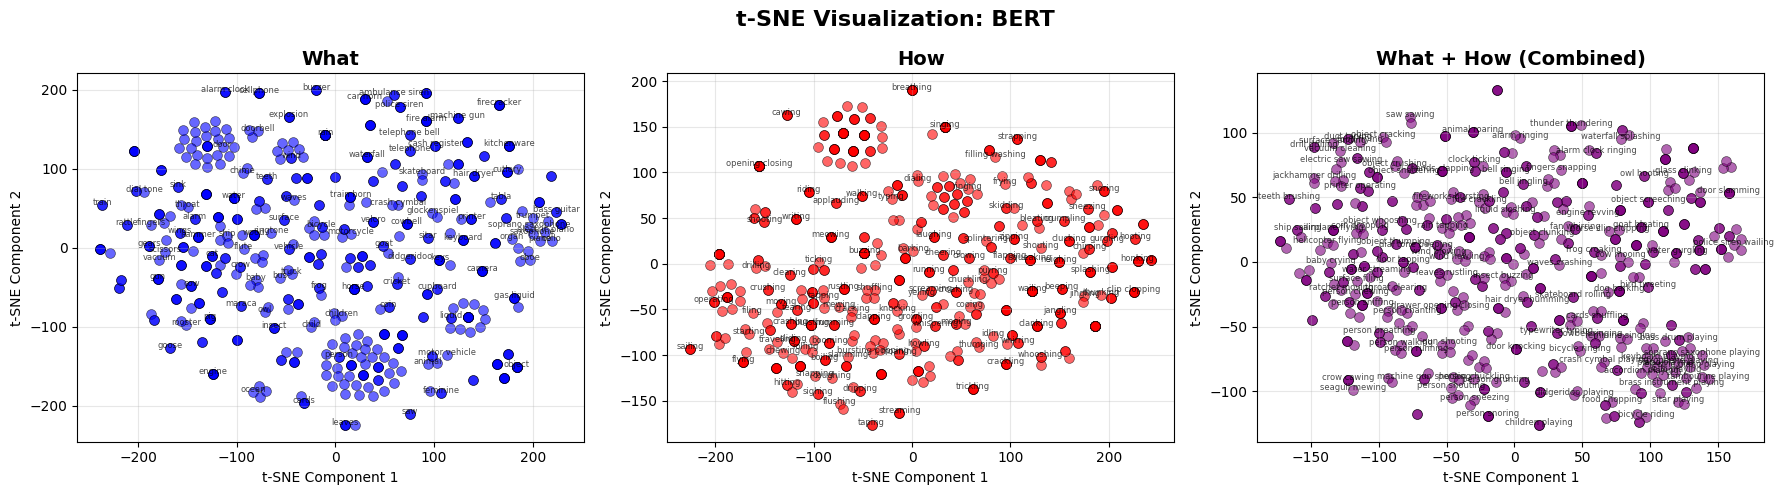


✓ t-SNE visualization completed for 'bert'


(array([[-228.96541  ,   -7.179088 ],
        [-238.5332   ,   -1.0520052],
        [ -14.167321 ,   26.194712 ],
        ...,
        [  18.274734 ,  -52.77429  ],
        [-127.18417  ,  -90.90352  ],
        [  97.83479  , -137.7699   ]], shape=(600, 2), dtype=float32),
 array([[  56.39378 ,   81.65055 ],
        [ 175.12032 ,  -35.690247],
        [  56.251755,   69.25378 ],
        ...,
        [ 225.19116 ,  -31.061037],
        [ -13.522906,  -18.27791 ],
        [  10.599114, -130.0304  ]], shape=(600, 2), dtype=float32),
 array([[ -6.399114 ,  69.6239   ],
        [  6.4023023,  60.27853  ],
        [ 48.24547  , -69.092896 ],
        ...,
        [ 74.12097  ,  18.058382 ],
        [ 77.5938   ,  40.20992  ],
        [-30.53922  , 100.792496 ]], shape=(600, 2), dtype=float32))

In [ ]:
# === t-SNE Visualization Function ===
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne_embeddings(embedding_type, n_components=2, perplexity=30, random_state=42, 
                         show_labels=True, max_labels=100, figsize=(18, 5)):
    """
    Visualize embeddings using t-SNE with three subplots: what, how, and what_how together.
    
    Parameters:
    -----------
    embedding_type : str
        Name of the embedding type (e.g., 'word2vec', 'bert', 'sentence-transformer', etc.)
    n_components : int
        Number of dimensions for t-SNE (default: 2)
    perplexity : float
        Perplexity parameter for t-SNE (default: 30)
    random_state : int
        Random state for reproducibility (default: 42)
    show_labels : bool
        Whether to show text labels on the plot (default: True)
    max_labels : int
        Maximum number of labels to show (to avoid overcrowding) (default: 100)
    figsize : tuple
        Figure size (width, height) (default: (18, 5))
    """
    
    # Construct paths
    base_path = f"../outputs/embeddings_{embedding_type}"
    what_path = f"{base_path}/what.npy"
    how_path = f"{base_path}/how.npy"
    what_how_path = f"{base_path}/what_how.npy"
    
    # Check if files exist
    import os
    if not os.path.exists(what_path):
        print(f"Error: Embeddings not found for '{embedding_type}'")
        print(f"Expected path: {base_path}")
        print("\nAvailable embedding types:")
        outputs_dir = "../outputs"
        if os.path.exists(outputs_dir):
            dirs = [d.replace("embeddings_", "") for d in os.listdir(outputs_dir) 
                   if os.path.isdir(os.path.join(outputs_dir, d)) and d.startswith("embeddings_")]
            for d in dirs:
                print(f"  - {d}")
        return
    
    # Load embeddings
    print(f"Loading embeddings for '{embedding_type}'...")
    emb_what = np.load(what_path)
    emb_how = np.load(how_path)
    emb_what_how = np.load(what_how_path)
    
    print(f"  - 'what' embeddings shape: {emb_what.shape}")
    print(f"  - 'how' embeddings shape: {emb_how.shape}")
    print(f"  - 'what_how' embeddings shape: {emb_what_how.shape}")
    
    # Apply t-SNE
    print(f"\nApplying t-SNE (perplexity={perplexity})...")
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state, verbose=1)
    
    print("  - Reducing 'what' embeddings...")
    tsne_what = tsne.fit_transform(emb_what)
    
    print("  - Reducing 'how' embeddings...")
    tsne_how = tsne.fit_transform(emb_how)
    
    print("  - Reducing 'what_how' embeddings...")
    tsne_what_how = tsne.fit_transform(emb_what_how)
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f't-SNE Visualization: {embedding_type.upper()}', fontsize=16, fontweight='bold')
    
    # Plot 1: What
    ax1 = axes[0]
    scatter1 = ax1.scatter(tsne_what[:, 0], tsne_what[:, 1], alpha=0.6, s=50, c='blue', edgecolors='black', linewidth=0.5)
    ax1.set_title('What', fontsize=14, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    ax1.grid(True, alpha=0.3)
    
    if show_labels:
        # Get unique texts and their first occurrence indices
        seen = {}
        unique_indices_what = []
        unique_texts_what = []
        for i, txt in enumerate(texts_what):
            if txt not in seen:
                seen[txt] = True
                unique_indices_what.append(i)
                unique_texts_what.append(txt)
        
        # Label only unique texts
        if len(unique_texts_what) <= max_labels:
            for idx, txt in zip(unique_indices_what, unique_texts_what):
                ax1.annotate(txt, (tsne_what[idx, 0], tsne_what[idx, 1]), 
                            fontsize=6, alpha=0.7, ha='center')
        else:
            # Show only a sample of unique labels
            sample_indices = np.random.choice(len(unique_texts_what), max_labels, replace=False)
            for sample_idx in sample_indices:
                idx = unique_indices_what[sample_idx]
                txt = unique_texts_what[sample_idx]
                ax1.annotate(txt, (tsne_what[idx, 0], tsne_what[idx, 1]), 
                            fontsize=6, alpha=0.7, ha='center')
    
    # Plot 2: How
    ax2 = axes[1]
    scatter2 = ax2.scatter(tsne_how[:, 0], tsne_how[:, 1], alpha=0.6, s=50, c='red', edgecolors='black', linewidth=0.5)
    ax2.set_title('How', fontsize=14, fontweight='bold')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.grid(True, alpha=0.3)
    
    if show_labels:
        # Get unique texts and their first occurrence indices
        seen = {}
        unique_indices_how = []
        unique_texts_how = []
        for i, txt in enumerate(texts_how):
            if txt not in seen:
                seen[txt] = True
                unique_indices_how.append(i)
                unique_texts_how.append(txt)
        
        # Label only unique texts
        if len(unique_texts_how) <= max_labels:
            for idx, txt in zip(unique_indices_how, unique_texts_how):
                ax2.annotate(txt, (tsne_how[idx, 0], tsne_how[idx, 1]), 
                            fontsize=6, alpha=0.7, ha='center')
        else:
            # Show only a sample of unique labels
            sample_indices = np.random.choice(len(unique_texts_how), max_labels, replace=False)
            for sample_idx in sample_indices:
                idx = unique_indices_how[sample_idx]
                txt = unique_texts_how[sample_idx]
                ax2.annotate(txt, (tsne_how[idx, 0], tsne_how[idx, 1]), 
                            fontsize=6, alpha=0.7, ha='center')
    
    # Plot 3: What_How (combined embeddings)
    ax3 = axes[2]
    scatter3 = ax3.scatter(tsne_what_how[:, 0], tsne_what_how[:, 1], alpha=0.6, s=50, 
                          c='purple', edgecolors='black', linewidth=0.5)
    ax3.set_title('What + How (Combined)', fontsize=14, fontweight='bold')
    ax3.set_xlabel('t-SNE Component 1')
    ax3.set_ylabel('t-SNE Component 2')
    ax3.grid(True, alpha=0.3)
    
    if show_labels:
        # Get unique texts and their first occurrence indices
        seen = {}
        unique_indices_what_how = []
        unique_texts_what_how = []
        for i, txt in enumerate(texts_what_how):
            if txt not in seen:
                seen[txt] = True
                unique_indices_what_how.append(i)
                unique_texts_what_how.append(txt)
        
        # Label only unique texts
        if len(unique_texts_what_how) <= max_labels:
            for idx, txt in zip(unique_indices_what_how, unique_texts_what_how):
                ax3.annotate(txt, (tsne_what_how[idx, 0], tsne_what_how[idx, 1]), 
                            fontsize=6, alpha=0.7, ha='center')
        else:
            # Show only a sample of unique labels
            sample_indices = np.random.choice(len(unique_texts_what_how), max_labels, replace=False)
            for sample_idx in sample_indices:
                idx = unique_indices_what_how[sample_idx]
                txt = unique_texts_what_how[sample_idx]
                ax3.annotate(txt, (tsne_what_how[idx, 0], tsne_what_how[idx, 1]), 
                            fontsize=6, alpha=0.7, ha='center')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✓ t-SNE visualization completed for '{embedding_type}'")
    
    return tsne_what, tsne_how, tsne_what_how

# Example usage:
#plot_tsne_embeddings('word2vec')
plot_tsne_embeddings('bert', perplexity=50, show_labels=True)
# plot_tsne_embeddings('sentence-transformer', max_labels=50)


In [ ]:
# === Collect All Embeddings into a Dictionary ===
# This cell creates a comprehensive dictionary with all computed embeddings

def load_all_embeddings(outputs_dir="../outputs"):
    """
    Load all embeddings from the outputs directory and organize them into a dictionary.
    
    Returns:
    --------
    embeddings_dict : dict
        Dictionary structure: {
            'model_name': {
                'what': numpy array,
                'how': numpy array,
                'what_how': numpy array
            },
            ...
        }
    """
    embeddings_dict = {}
    
    # Get all embedding directories
    if not os.path.exists(outputs_dir):
        print(f"Error: Outputs directory '{outputs_dir}' not found!")
        return embeddings_dict
    
    embedding_dirs = [d for d in os.listdir(outputs_dir) 
                     if os.path.isdir(os.path.join(outputs_dir, d)) and d.startswith("embeddings_")]
    
    print(f"Found {len(embedding_dirs)} embedding directories\n")
    
    for emb_dir in sorted(embedding_dirs):
        # Extract model name (remove "embeddings_" prefix)
        model_name = emb_dir.replace("embeddings_", "")
        model_path = os.path.join(outputs_dir, emb_dir)
        
        # Check for required files
        what_path = os.path.join(model_path, "what.npy")
        how_path = os.path.join(model_path, "how.npy")
        what_how_path = os.path.join(model_path, "what_how.npy")
        
        # Load embeddings if they exist
        model_embeddings = {}
        all_exist = True
        
        if os.path.exists(what_path):
            model_embeddings['what'] = np.load(what_path)
        else:
            print(f"  ⚠ {model_name}: 'what.npy' not found")
            all_exist = False
            
        if os.path.exists(how_path):
            model_embeddings['how'] = np.load(how_path)
        else:
            print(f"  ⚠ {model_name}: 'how.npy' not found")
            all_exist = False
            
        if os.path.exists(what_how_path):
            model_embeddings['what_how'] = np.load(what_how_path)
        else:
            print(f"  ⚠ {model_name}: 'what_how.npy' not found")
            all_exist = False
        
        if all_exist:
            embeddings_dict[model_name] = model_embeddings
            print(f"  ✓ {model_name}: loaded (what: {model_embeddings['what'].shape}, "
                  f"how: {model_embeddings['how'].shape}, "
                  f"what_how: {model_embeddings['what_how'].shape})")
        else:
            print(f"  ✗ {model_name}: incomplete, skipping")
    
    return embeddings_dict

# Load all embeddings
print("="*60)
print("Loading all embeddings into dictionary...")
print("="*60)
all_embeddings = load_all_embeddings()

print("\n" + "="*60)
print("SUMMARY: Embeddings Dictionary")
print("="*60)
print(f"\nTotal models loaded: {len(all_embeddings)}")
print(f"\nAvailable models:")
for model_name in sorted(all_embeddings.keys()):
    emb = all_embeddings[model_name]
    print(f"  - {model_name}:")
    print(f"      what: {emb['what'].shape}")
    print(f"      how: {emb['how'].shape}")
    print(f"      what_how: {emb['what_how'].shape}")

print("\n" + "="*60)
print("Dictionary structure: all_embeddings['model_name']['what'|'how'|'what_how']")
print("="*60)
print("\nExample usage:")
print("  all_embeddings['word2vec']['what']")
print("  all_embeddings['bert']['how']")
print("  all_embeddings['sentence-transformer']['what_how']")

# Save the embeddings dictionary using pickle for easy loading later
import pickle
pickle_path = "../outputs/all_embeddings_dict.pkl"
print(f"\n{'='*60}")
print(f"Saving embeddings dictionary to: {pickle_path}")
print(f"{'='*60}")
with open(pickle_path, 'wb') as f:
    pickle.dump(all_embeddings, f)
print(f"✓ Embeddings dictionary saved successfully!")
print(f"  To load later: all_embeddings = pickle.load(open('{pickle_path}', 'rb'))")


Loading all embeddings into dictionary...
Found 11 embedding directories

  ✓ bert: loaded (what: (600, 768), how: (600, 768), what_how: (600, 768))
  ✓ distilbert: loaded (what: (600, 768), how: (600, 768), what_how: (600, 768))
  ✓ fasttext: loaded (what: (600, 300), how: (600, 300), what_how: (600, 300))
  ✓ glove: loaded (what: (600, 300), how: (600, 300), what_how: (600, 300))
  ✓ gpt2: loaded (what: (600, 768), how: (600, 768), what_how: (600, 768))
  ✓ minilm: loaded (what: (600, 384), how: (600, 384), what_how: (600, 384))
  ✓ multilingual_bert: loaded (what: (600, 768), how: (600, 768), what_how: (600, 768))
  ✓ multilingual_st: loaded (what: (600, 768), how: (600, 768), what_how: (600, 768))
  ✓ roberta: loaded (what: (600, 768), how: (600, 768), what_how: (600, 768))
  ✓ sentence-transformer: loaded (what: (600, 768), how: (600, 768), what_how: (600, 768))
  ✓ word2vec: loaded (what: (600, 300), how: (600, 300), what_how: (600, 300))

SUMMARY: Embeddings Dictionary

Total mo

In [ ]:
all_embeddings

{'bert': {'what': array([[-0.02815508,  0.16657236,  0.06065377, ..., -0.00806475,
           0.21433839,  0.278486  ],
         [-0.02815508,  0.16657236,  0.06065377, ..., -0.00806475,
           0.21433839,  0.278486  ],
         [-0.27624258,  0.18332446, -0.15086184, ..., -0.19634874,
           0.1145386 ,  0.06780271],
         ...,
         [-0.4165159 ,  0.1070044 , -0.12735577, ..., -0.2058599 ,
           0.02350675,  0.24462704],
         [-0.38096502,  0.02100931,  0.01413567, ...,  0.00388308,
           0.0775436 ,  0.13118827],
         [-0.41378278,  0.36796692, -0.60552937, ..., -0.17401978,
          -0.06044459,  0.6833082 ]], shape=(600, 768), dtype=float32),
  'how': array([[-0.21567503,  0.35257477,  0.03961558, ...,  0.04923001,
           0.02223345,  0.04266983],
         [-0.5228966 ,  0.44590312, -0.3420173 , ..., -0.03087444,
          -0.3673207 , -0.27608046],
         [-0.21567503,  0.35257477,  0.03961558, ...,  0.04923001,
           0.02223345,  0.042